In [339]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/nyse/securities.csv
/kaggle/input/nyse/fundamentals.csv
/kaggle/input/nyse/prices-split-adjusted.csv
/kaggle/input/nyse/prices.csv


In [340]:
import numpy as np 
import pandas as pd 

from subprocess import check_output

import keras
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import LSTM , GRU
from sklearn.model_selection import  train_test_split
import time 
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from math import sqrt

import matplotlib.pyplot as plt
from numpy import newaxis

import math, time # Helper Libraries

In [341]:
prices =  pd.read_csv('../input/nyse/prices-split-adjusted.csv', index_col = 0)
print(type(prices))
prices

<class 'pandas.core.frame.DataFrame'>


,symbol,open,close,low,high,volume
date,,,,,,
2016-01-05,WLTW,123.430000,125.839996,122.309998,126.250000,2163600.0
2016-01-06,WLTW,125.239998,119.980003,119.940002,125.540001,2386400.0
2016-01-07,WLTW,116.379997,114.949997,114.930000,119.739998,2489500.0
2016-01-08,WLTW,115.480003,116.620003,113.500000,117.440002,2006300.0
2016-01-11,WLTW,117.010002,114.970001,114.089996,117.330002,1408600.0
...,...,...,...,...,...,...
2016-12-30,ZBH,103.309998,103.199997,102.849998,103.930000,973800.0
2016-12-30,ZION,43.070000,43.040001,42.689999,43.310001,1938100.0
2016-12-30,ZTS,53.639999,53.529999,53.270000,53.740002,1701200.0


In [342]:
#prices["adj close"] = prices.close
#prices.drop(['close'], 1, inplace=True)

In [343]:
prices.head()

,symbol,open,close,low,high,volume
date,,,,,,
2016-01-05,WLTW,123.430000,125.839996,122.309998,126.250000,2163600.0
2016-01-06,WLTW,125.239998,119.980003,119.940002,125.540001,2386400.0
2016-01-07,WLTW,116.379997,114.949997,114.930000,119.739998,2489500.0
2016-01-08,WLTW,115.480003,116.620003,113.500000,117.440002,2006300.0
2016-01-11,WLTW,117.010002,114.970001,114.089996,117.330002,1408600.0


In [344]:
prices.describe()

,open,close,low,high,volume
count,851264.000000,851264.000000,851264.000000,851264.000000,8.512640e+05
mean,64.993618,65.011913,64.336541,65.639748,5.415113e+06
std,75.203893,75.201216,74.459518,75.906861,1.249468e+07
min,1.660000,1.590000,1.500000,1.810000,0.000000e+00
25%,31.270000,31.292776,30.940001,31.620001,1.221500e+06
50%,48.459999,48.480000,47.970001,48.959999,2.476250e+06
75%,75.120003,75.139999,74.400002,75.849998,5.222500e+06
max,1584.439941,1578.130005,1549.939941,1600.930054,8.596434e+08


In [345]:
prices.groupby('symbol').count()

,open,close,low,high,volume
symbol,,,,,
A,1762,1762,1762,1762,1762
AAL,1762,1762,1762,1762,1762
AAP,1762,1762,1762,1762,1762
AAPL,1762,1762,1762,1762,1762
ABBV,1008,1008,1008,1008,1008
...,...,...,...,...,...
YHOO,1762,1762,1762,1762,1762
YUM,1762,1762,1762,1762,1762
ZBH,1762,1762,1762,1762,1762


In [346]:
prices.info()

<class 'pandas.core.frame.DataFrame'>
Index: 851264 entries, 2016-01-05 to 2016-12-30
Data columns (total 6 columns):
symbol    851264 non-null object
open      851264 non-null float64
close     851264 non-null float64
low       851264 non-null float64
high      851264 non-null float64
volume    851264 non-null float64
dtypes: float64(5), object(1)
memory usage: 45.5+ MB


In [347]:
print('\nNumber of Different Stocks : ', len(list(set(prices.symbol))))


Number of Different Stocks :  501


In [348]:
#  Number of Unique Ticker Symbols
print(set(prices['symbol']))

{'HRL', 'VLO', 'RRC', 'CMA', 'EFX', 'ADM', 'AIG', 'UAL', 'AIZ', 'DVN', 'EVHC', 'HAR', 'AET', 'CHRW', 'MAT', 'YHOO', 'ENDP', 'KHC', 'UNM', 'CMCSA', 'RHT', 'NWS', 'WM', 'WYNN', 'FL', 'EQIX', 'GRMN', 'JWN', 'EMN', 'EQR', 'TEL', 'ALXN', 'SNA', 'CME', 'LVLT', 'VMC', 'FRT', 'MTB', 'LB', 'KIM', 'IDXX', 'EXC', 'SHW', 'AKAM', 'HUM', 'REGN', 'COO', 'NBL', 'SYK', 'WFM', 'JEC', 'NLSN', 'GOOGL', 'COTY', 'BXP', 'SRCL', 'JCI', 'CFG', 'KORS', 'JNPR', 'MA', 'IR', 'TSO', 'ADBE', 'BBT', 'TDG', 'AME', 'HAL', 'CHK', 'HSY', 'STZ', 'XEL', 'PKI', 'LEN', 'BBBY', 'ACN', 'ADP', 'KLAC', 'COL', 'MO', 'CMI', 'OKE', 'USB', 'QCOM', 'PG', 'PNW', 'HST', 'SNI', 'AMT', 'SYY', 'BAX', 'WY', 'D', 'GIS', 'EXR', 'PDCO', 'HIG', 'URI', 'NEE', 'BK', 'XRX', 'SWKS', 'CSX', 'ECL', 'TRV', 'PBI', 'STX', 'APC', 'AMP', 'INTU', 'MLM', 'PX', 'DIS', 'XRAY', 'ZBH', 'SYMC', 'PPG', 'DLR', 'ZTS', 'MAR', 'APA', 'FLS', 'KMI', 'ORCL', 'FLR', 'SPG', 'TGNA', 'VIAB', 'EBAY', 'HES', 'MRK', 'LH', 'MPC', 'CVX', 'OXY', 'NOV', 'WFC', 'MUR', 'XYL', 'CNP'

In [349]:
prices['symbol'].value_counts()

HST     1762
IDXX    1762
XL      1762
COF     1762
BLL     1762
        ... 
KHC      378
HPE      304
CSRA     284
WLTW     251
FTV      126
Name: symbol, Length: 501, dtype: int64

In [350]:
prices[prices["symbol"] == "CSCO"].tail()

,symbol,open,close,low,high,volume
date,,,,,,
2016-12-23,CSCO,30.540001,30.530001,30.400000,30.600000,9167500.0
2016-12-27,CSCO,30.639999,30.680000,30.600000,30.820000,14175500.0
2016-12-28,CSCO,30.700001,30.420000,30.350000,30.770000,12022200.0
2016-12-29,CSCO,30.370001,30.459999,30.330000,30.549999,10995600.0
2016-12-30,CSCO,30.559999,30.219999,30.129999,30.600000,20190000.0


In [351]:
# Extracting A Particular Price for Stock in Symbols
#  Using CSCO As An Example
cisc = prices[prices['symbol']=='CSCO']
cisc.shape

(1762, 6)

In [352]:
cisco = prices[prices['symbol']=='CSCO']
print(cisco)
print(type(cisco))
print(cisco.close.values)
cisco_stock_prices = cisco.close.values.astype('float32')
cisco_stock_prices = cisco_stock_prices.reshape(1762, 1)
cisco_stock_prices.shape

           symbol       open      close        low       high      volume
date                                                                     
2010-01-04   CSCO  24.110001  24.690001  24.010000  24.840000  59853700.0
2010-01-05   CSCO  24.600000  24.580000  24.379999  24.730000  45124500.0
2010-01-06   CSCO  24.540001  24.420000  24.340000  24.740000  35715700.0
2010-01-07   CSCO  24.299999  24.530001  24.170000  24.570000  31531200.0
2010-01-08   CSCO  24.379999  24.660000  24.250000  24.700001  39115900.0
...           ...        ...        ...        ...        ...         ...
2016-12-23   CSCO  30.540001  30.530001  30.400000  30.600000   9167500.0
2016-12-27   CSCO  30.639999  30.680000  30.600000  30.820000  14175500.0
2016-12-28   CSCO  30.700001  30.420000  30.350000  30.770000  12022200.0
2016-12-29   CSCO  30.370001  30.459999  30.330000  30.549999  10995600.0
2016-12-30   CSCO  30.559999  30.219999  30.129999  30.600000  20190000.0

[1762 rows x 6 columns]
<class 'panda

(1762, 1)

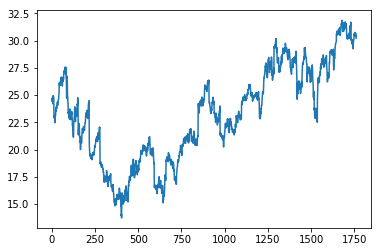

In [353]:
plt.plot(cisco_stock_prices)
plt.show()

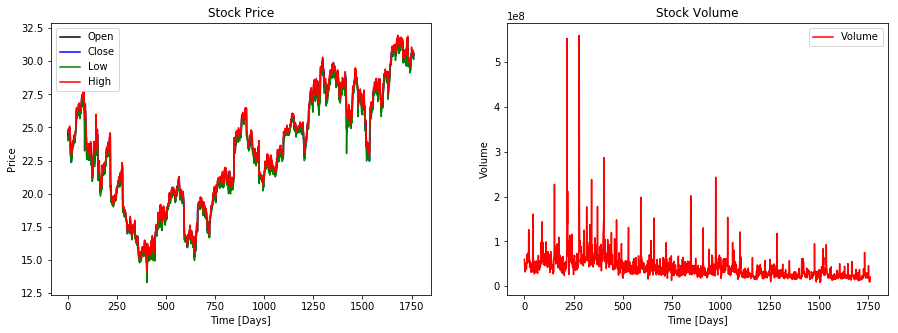

In [354]:
plt.figure(figsize=(15, 5));
plt.subplot(1,2,1);
plt.plot(prices[prices.symbol == 'CSCO'].open.values, color='black', label='Open')
plt.plot(prices[prices.symbol == 'CSCO'].close.values, color='blue', label='Close')
plt.plot(prices[prices.symbol == 'CSCO'].low.values, color='green', label='Low')
plt.plot(prices[prices.symbol == 'CSCO'].high.values, color='red', label='High')
plt.title('Stock Price')
plt.xlabel('Time [Days]')
plt.ylabel('Price')
plt.legend(loc='best')
#plt.show()

plt.subplot(1,2,2);
plt.plot(prices[prices.symbol == 'CSCO'].volume.values, color='red', label='Volume')
plt.title('Stock Volume')
plt.xlabel('Time [Days]')
plt.ylabel('Volume')
plt.legend(loc='best');

In [355]:
# Selection of CISCO As The Stock to Analyse
prices = prices[prices.symbol == 'CSCO']
prices.drop(['symbol'],1,inplace=True)
prices.head()

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,open,close,low,high,volume
date,,,,,
2010-01-04,24.110001,24.690001,24.010000,24.840000,59853700.0
2010-01-05,24.600000,24.580000,24.379999,24.730000,45124500.0
2010-01-06,24.540001,24.420000,24.340000,24.740000,35715700.0
2010-01-07,24.299999,24.530001,24.170000,24.570000,31531200.0
2010-01-08,24.379999,24.660000,24.250000,24.700001,39115900.0


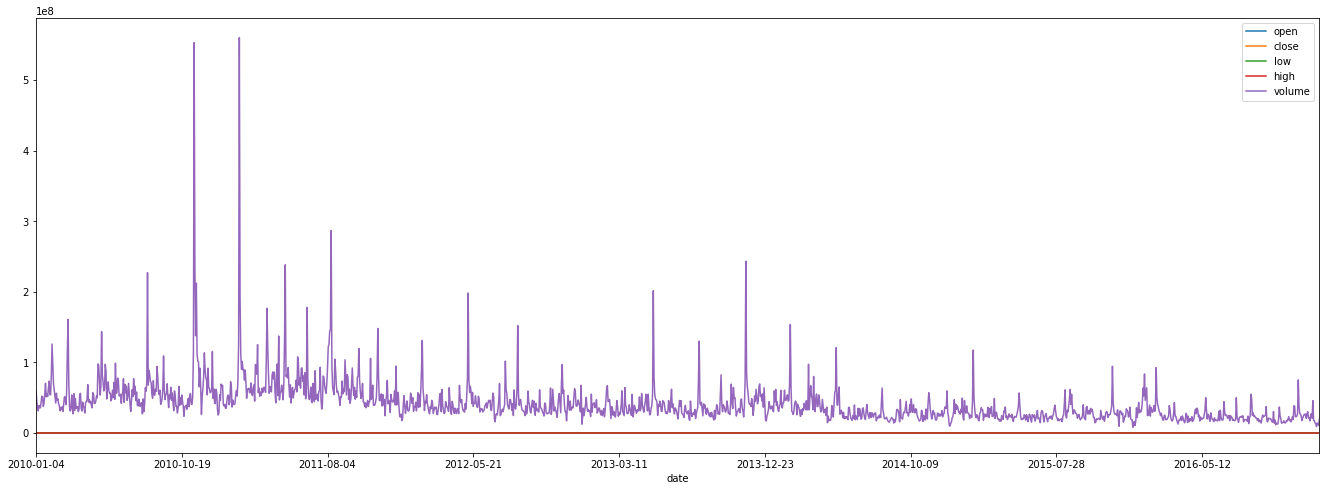

In [356]:
prices.plot(figsize=(23,8))

In [357]:
prices.isna().sum()

open      0
close     0
low       0
high      0
volume    0
dtype: int64

In [358]:
prices.describe()

,open,close,low,high,volume
count,1762.000000,1762.000000,1762.000000,1762.000000,1.762000e+03
mean,23.238655,23.246436,23.036771,23.447395,4.198613e+07
std,4.343675,4.353713,4.333605,4.362779,3.089350e+07
min,13.930000,13.730000,13.300000,14.120000,8.166300e+06
25%,19.840000,19.830000,19.662500,19.959999,2.536715e+07
50%,23.245000,23.245000,22.990000,23.500000,3.529625e+07
75%,26.927500,26.879999,26.655000,27.170000,5.017315e+07
max,31.930000,31.870001,31.750000,31.950001,5.600402e+08


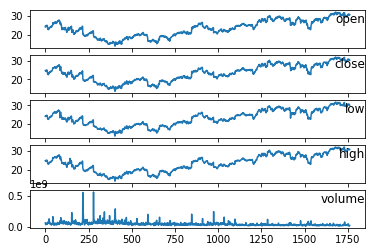

In [359]:
data = prices.values
# Specifying Columns to Plot
features = [0, 1, 2, 3, 4]
i = 1
# Plotting Each Column
plt.figure()
for feature in features:
    plt.subplot(len(features), 1, i)
    plt.plot(data[:, feature])
    plt.title(prices.columns[feature], y=0.5, loc='right')
    i += 1
plt.show()

In [360]:
prices["adj close"] = prices.close
prices.drop(['close'], 1, inplace=True)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: h

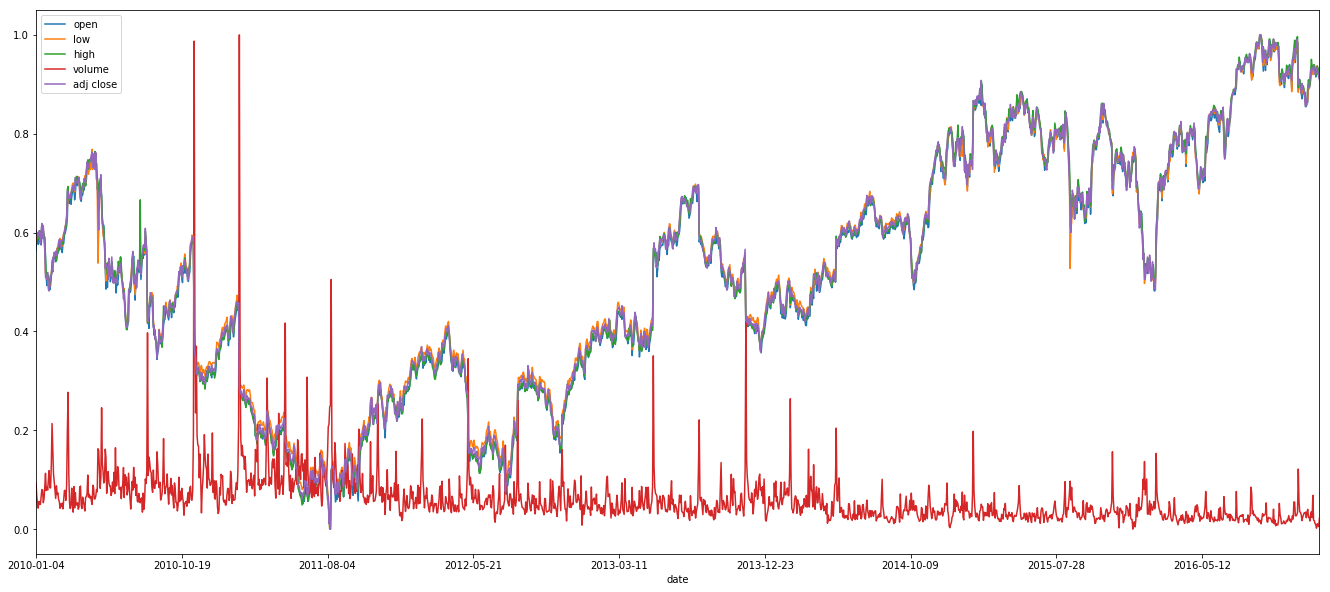

In [361]:
#  Normalizing The Data
def normalize_data(prices):
    min_max_scaler = preprocessing.MinMaxScaler()
    prices['open'] = min_max_scaler.fit_transform(prices.open.values.reshape(-1,1))
    prices['high'] = min_max_scaler.fit_transform(prices.high.values.reshape(-1,1))
    prices['low'] = min_max_scaler.fit_transform(prices.low.values.reshape(-1,1))
    prices['volume'] = min_max_scaler.fit_transform(prices.volume.values.reshape(-1,1))
    prices['adj close'] = min_max_scaler.fit_transform(prices['adj close'].values.reshape(-1,1))
    return prices
prices = normalize_data(prices)
prices.plot(figsize=(23,10))

In [362]:
prices = normalize_data(prices)
prices.head()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: h

,open,low,high,volume,adj close
date,,,,,
2010-01-04,0.565556,0.580488,0.601234,0.093658,0.604190
2010-01-05,0.592778,0.600542,0.595064,0.066969,0.598126
2010-01-06,0.589444,0.598374,0.595625,0.049920,0.589305
2010-01-07,0.576111,0.589160,0.586091,0.042337,0.595369
2010-01-08,0.580555,0.593496,0.593382,0.056081,0.602536
